# <span style='color:#DB822E'>Activity 21: Switch vs. Access Point</span>

In this activity we'll build our own custom deep learning image classifier to compare images of Aruba devices and determine if the picture is an AP or switch. We'll use a collection of Aruba images from the web. We'll then load those images into a pipeline and use it to classify images as a zero or one binary classification type problem. 

We'll be using [Tensorflow](https://www.tensorflow.org/), specifically the [Keras API](https://www.tensorflow.org/guide/keras) within [Tensorflow](https://www.tensorflow.org/) to build this deep learning classifier.

>TensorFlow is an end-to-end open source platform for machine learning. TensorFlow is a rich system for managing all aspects of a machine learning system; however, this class focuses on using a particular TensorFlow API to develop and train machine learning models.

>Keras is the high-level API (developed by Google) of the TensorFlow platform. It provides an approachable, highly-productive interface for solving machine learning (ML) problems, with a focus on modern deep learning. Keras covers every step of the machine learning workflow, from data processing to hyperparameter tuning to deployment.


## STEP 1 - First we'll load all the necessary Python modules for this activity.

In [1]:
from IPython.display import display
from IPython.display import Image, display, Markdown
import logging
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

logging.getLogger().setLevel(logging.CRITICAL)


display(Markdown('<span style="color: #14B326">Done!</span>'))


<span style="color: #14B326">Done!</span>

***

## STEP 2


Next we'll be using Tensorflow's Keras sequential api utility to load the images from our data direcotry. This will make it easier to build our custom deep learning module over Tensorflows dataset utility. 


In [2]:
### Uncomment the following if running your own server that has a GPU.
### The following will prevent tensorflow use ALL of your GPU
### or you'll get out of memory errors with other applications
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

data = tf.keras.utils.image_dataset_from_directory(
    directory="data"
    )

display(Markdown('<span style="color: #14B326">Done!</span>'))


Found 297 files belonging to 2 classes.


<span style="color: #14B326">Done!</span>

<span style='color:red'>The following may generate an error. The error can be ignored.</span>

***
## STEP 3

The following will load the dataset into numpy and cycle through the shapes using the Python generator, next().


In [3]:
data_iterator = data.as_numpy_iterator()  # type: ignore
batch = data_iterator.next()

display(Markdown('<span style="color: #14B326">Done!</span>'))


<span style="color: #14B326">Done!</span>


***


## STEP 4 -  Print the batch

index 0 or shape, is the image data
index 1 is the label

32 is the batch (default)
256, 256 is auto resizing it to 256x256 px
3 is RGB (red green blue)

In [4]:
# Print the batch 
# 0 is access points
# 1 is switches

display(batch[0].shape)
display(batch[1])

display(Markdown('<span style="color: #14B326">Done!</span>'))


(32, 256, 256, 3)

array([1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1], dtype=int32)

<span style="color: #14B326">Done!</span>

***

## STEP 5 - Show images from batch

Here we'll display some of the data so we can see if it looks correct.
ncols is the number of columns
figsize is the figure size, so 20x20 to fit on our screen
:4 says to show 4 images.
imshow is the image
title is the title of the image, which is 0 or 1

Why is AP 0 and Switch 1?

This is due to how the directories or were imported. APs were first, then switches.

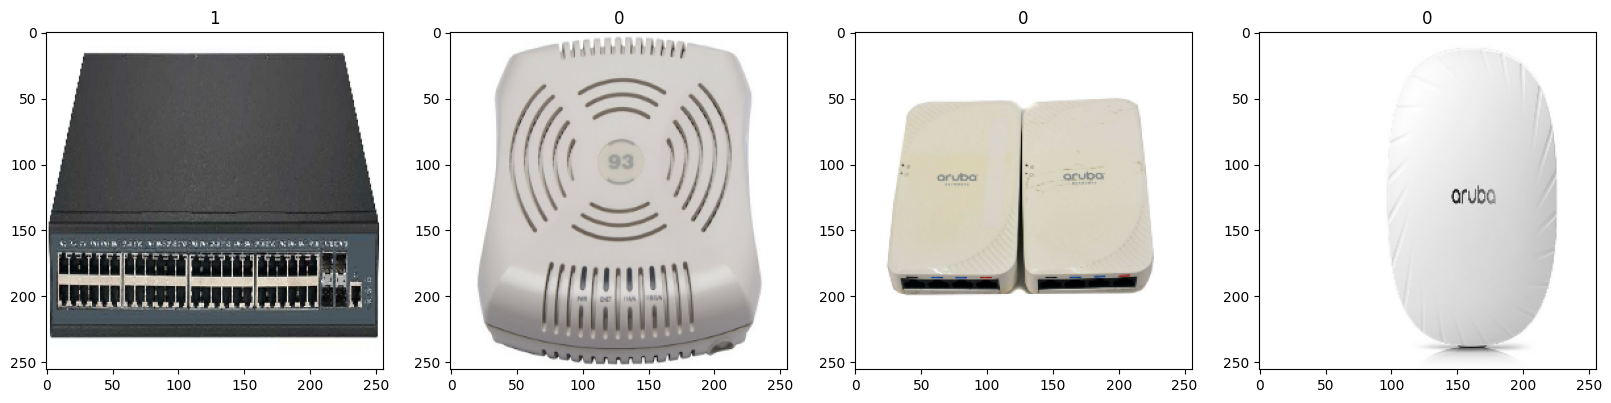

<span style="color: #14B326">Done!</span>

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(np.uint8))
    ax[idx].title.set_text(batch[1][idx])

plt.show()

display(Markdown('<span style="color: #14B326">Done!</span>'))


***

## STEP 6 - Preprocessing our data/Scale the Data
We then need to scale the data to 255 colors. Each channel (R,G,B) have 256 colors, but we start at 0, which is why we're at 255.

In [6]:


data = data.map(lambda x, y: (x/255, y))  # type: ignore
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

display(Markdown('<span style="color: #14B326">Done!</span>'))


<span style="color: #14B326">Done!</span>

***

## STEP 7 - Display Scaled Data

Again, we display the data now that we've scaled the data

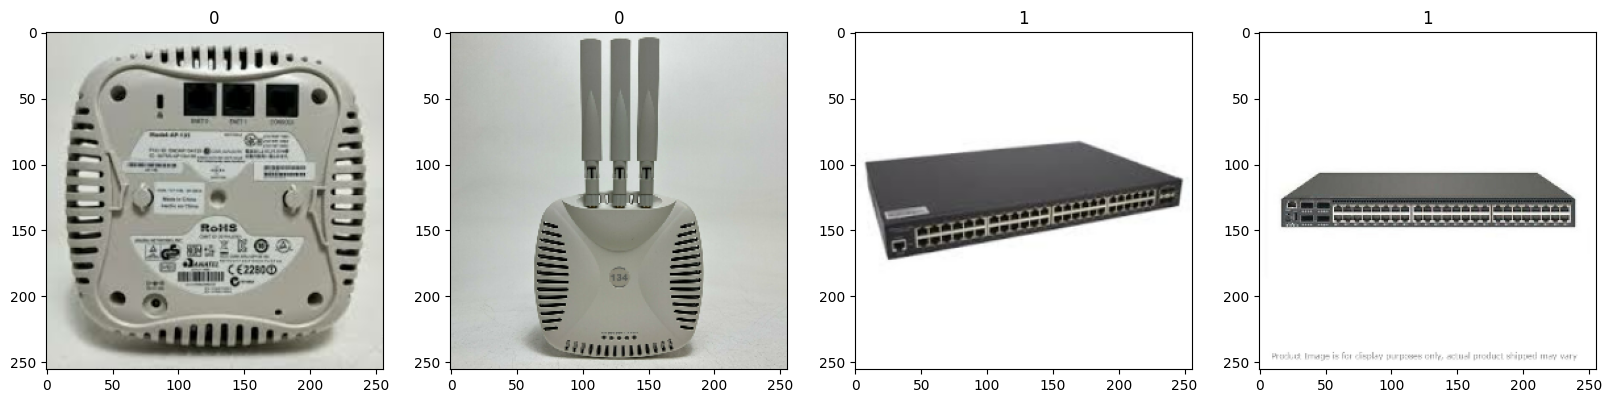

<span style="color: #14B326">Done!</span>

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

plt.show()

display(Markdown('<span style="color: #14B326">Done!</span>'))


## STEP 8 - SPLIT DATA

In this section, we'll be split the data just as we did in our previous activities.
We'll do 70% of the images for training
then, 20% for validating the images
finally, 10% to test that data. The testing will be done at the end of the process.

In [8]:
# print(len(data))
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

# print(train_size+val_size+test_size)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

display(Markdown('<span style="color: #14B326">Done!</span>'))


<span style="color: #14B326">Done!</span>

***


## STEP 9 - Build Deep Learning Model

In [9]:

from tensorflow.keras.layers import (Conv2D, Dense, Flatten, MaxPooling2D)
from tensorflow.keras.models import Sequential  # type: ignore

model = Sequential()

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

display(Markdown('<span style="color: #14B326">Done!</span>'))


<span style="color: #14B326">Done!</span>

In [10]:
# Print the model
print(model.summary())

display(Markdown('<span style="color: #14B326">Done!</span>'))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

<span style="color: #14B326">Done!</span>

***

## STEP 10 Train Model

The training process can take a significant amount of time. On my personal machine, this took roughly 5 seconds. 
On shared hosting and training environments, <span style="color: #ff0000">this can take 2 or more minutes!</span>

In [11]:

logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

display(Markdown('<span style="color: #14B326">Done!</span>'))


Epoch 1/20
7/7 [==============================] - 8s 280ms/step - loss: 0.9278 - accuracy: 0.5982 - val_loss: 0.6187 - val_accuracy: 0.7123
Epoch 2/20
7/7 [==============================] - 3s 239ms/step - loss: 0.5046 - accuracy: 0.7054 - val_loss: 0.4655 - val_accuracy: 0.6986
Epoch 3/20
7/7 [==============================] - 3s 241ms/step - loss: 0.3947 - accuracy: 0.7366 - val_loss: 0.3111 - val_accuracy: 0.7808
Epoch 4/20
7/7 [==============================] - 2s 207ms/step - loss: 0.3144 - accuracy: 0.8125 - val_loss: 0.2797 - val_accuracy: 0.8356
Epoch 5/20
7/7 [==============================] - 2s 209ms/step - loss: 0.2938 - accuracy: 0.8482 - val_loss: 0.2216 - val_accuracy: 0.9452
Epoch 6/20
7/7 [==============================] - 2s 221ms/step - loss: 0.2575 - accuracy: 0.9107 - val_loss: 0.2638 - val_accuracy: 0.9726
Epoch 7/20
7/7 [==============================] - 2s 208ms/step - loss: 0.1785 - accuracy: 0.9598 - val_loss: 0.1226 - val_accuracy: 0.9589
Epoch 8/20
7/7 [====

<span style="color: #14B326">Done!</span>

***

## STEP 11 - Plot Performance
### Loss

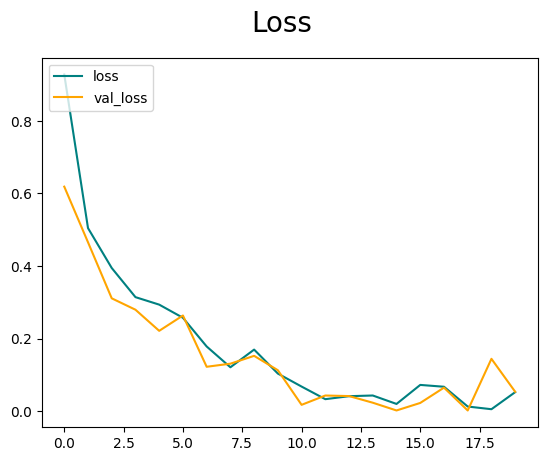

<span style="color: #14B326">Done!</span>

In [12]:

##
# Loss
#
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

display(Markdown('<span style="color: #14B326">Done!</span>'))


### Accuracy

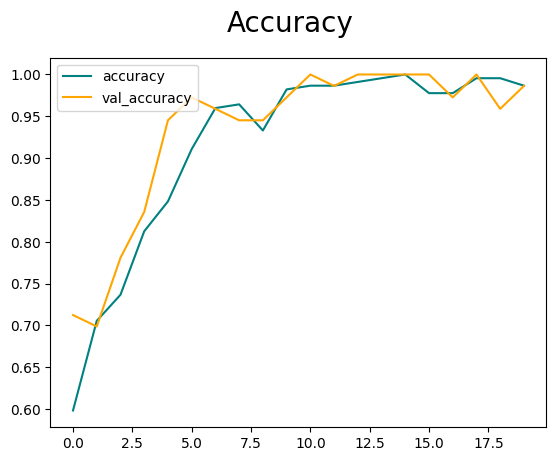

<span style="color: #14B326">Done!</span>

In [13]:
##
# Accuracy
#
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

display(Markdown('<span style="color: #14B326">Done!</span>'))


### Evaluate Model

In [ ]:
####
# Evaluate Model
#
# from tensorflow.keras.metrics import BinaryAccuracy  # type: ignore
# from tensorflow.keras.metrics import Precision, Recall

# pre = Precision()
# re = Recall()
# acc = BinaryAccuracy()

# for batch in test.as_numpy_iterator():
#     X, y = batch
#     yhat = model.predict(X)
#     pre.update_state(y, yhat)
#     re.update_state(y, yhat)
#     acc.update_state(y, yhat)

# print(pre.result(), re.result(), acc.result())

display(Markdown('<span style="color: #14B326">Done!</span>'))


## STEP 12 - Test Model

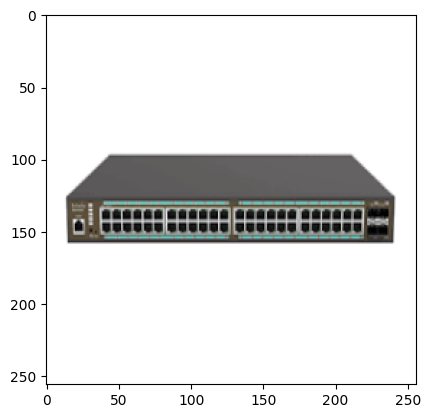

1/1 [==============================] - 0s 204ms/step


'Predicted class of image is a Switch'

<span style="color: #14B326">Done!</span>

In [14]:
####
# Test Model
#
import cv2

img = cv2.imread('test_images/test_switch-1.png')
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))  # type: ignore
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))  # type: ignore

if yhat > 0.5:
    display('Predicted class of image is a Switch')
else:
    display('Predicted class of image is an Access Point')
    
display(Markdown('<span style="color: #14B326">Done!</span>'))


## Step 13 - Save Model

In [15]:
####
# Save Model
#
import os
model.save(os.path.join('models', 'imageclassifier.keras'))

display(Markdown('<span style="color: #14B326">Done!</span>'))


<span style="color: #14B326">Done!</span>

## You have completed Activity 21.

[Start Activity 22](Activity22.ipynb)